## Here you can apply different image augmentations 

## And you can see how your model predicts on transformed images

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import time
import torch
import cv2
import numpy as np
import albumentations as albu
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch.nn.functional as F

from PIL import Image
from utils.utils import load_classes, non_max_suppression
from utils.datasets import resize
from models import Darknet

In [2]:
image_folder = "../data/samples"
model_def = "../config/yolov3.cfg"
weights_path = "../weights/yolov3.weights"
class_path = "../data/coco.names"
conf_thres = 0.8
nms_thres = 0.4
batch_size = 1
n_cpu = 1
img_size = 416

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def rescale_boxes(boxes, current_size, original_size):
    """Rescales bounding boxes to the original shape

    Args:
        boxes (list(torch.Tensor)): Each torch.Tensor has shape = (N, 7) where N - number of bbox in img.
            Each bbox looks like: (x1, y1, x2, y2, object_conf, class_score, class_label)
        current_size: the size of the image that we use for model prediction
        original_size: original image size

    """
    orig_h, orig_w = original_size
    boxes = boxes.clone()

    boxes[:, 0] = (boxes[:, 0] / current_size) * orig_w
    boxes[:, 1] = (boxes[:, 1] / current_size) * orig_h
    boxes[:, 2] = (boxes[:, 2] / current_size) * orig_w
    boxes[:, 3] = (boxes[:, 3] / current_size) * orig_h

    return boxes

In [4]:
def load_original_image(img_path, img_size):
    """Load image and resize it"""
    img = np.array(Image.open(img_path))
    resized_img = resize(transforms.ToTensor()(img), img_size).unsqueeze(0)
    return img, resized_img

In [5]:
def load_augmented_image(img_path, img_size, albu_transform):
    """Load image, apply augmentations and resize it"""
    img = np.array(Image.open(img_path))
    augmented_img = albu_transform(image=img)['image']
    resized_img = resize(transforms.ToTensor()(augmented_img), img_size).unsqueeze(0)
    
    return augmented_img, resized_img

### Load pretrained model

In [6]:
model = Darknet(model_def, img_size=img_size).to(device)

if weights_path.endswith(".weights"):
    # Load darknet weights
    model.load_darknet_weights(weights_path)
else:
    # Load checkpoint weights
    model.load_state_dict(torch.load(weights_path))

model.eval()  # Set in evaluation mode

classes = load_classes(class_path)  # Extracts class labels from file
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

### Define augmentations

In [7]:
albu_transform = albu.Compose(
        [
           albu.RandomResizedCrop(
                scale=(0.7, 1.0),
                height=img_size,
                width=img_size,
                p=1,
            ),
            albu.ShiftScaleRotate(
                border_mode=cv2.BORDER_CONSTANT, rotate_limit=10, scale_limit=0, p=0.5, mask_value=255
            ),
            albu.ImageCompression(quality_lower=50, quality_upper=100, p=0.5),
            albu.RandomBrightnessContrast(p=0.5)
        ]
    )

### Create dict of paths to images on which we will check the model

In [8]:
img_path_dict = {img_name.split('.')[0]: os.path.join(image_folder, img_name) 
                 for img_name in os.listdir(image_folder)}
img_path_dict

{'messi': '../data/samples/messi.jpg',
 'field': '../data/samples/field.jpg',
 'person': '../data/samples/person.jpg',
 'eagle': '../data/samples/eagle.jpg',
 'room': '../data/samples/room.jpg',
 'giraffe': '../data/samples/giraffe.jpg',
 'herd_of_horses': '../data/samples/herd_of_horses.jpg',
 'street': '../data/samples/street.jpg',
 'dog': '../data/samples/dog.jpg'}

### Get detections for images

In [11]:
imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index
img_path = img_path_dict['street'] # choose image for which we will make prediction

origin_imgs = load_original_image(img_path, img_size)
aug_imgs = load_augmented_image(img_path, img_size, albu_transform)

# Get detections
for (img, resized_img) in [origin_imgs, aug_imgs]:
    resized_img = resized_img.requires_grad_(False).to(device)
    with torch.no_grad():
        detections = model(resized_img)
        detections = non_max_suppression(detections, conf_thres, nms_thres)

    imgs.append(img)
    img_detections.extend(detections)

### Iterate through images and plot of detections


Original image
Label: car, Conf: 0.99973
Label: car, Conf: 0.99657
Label: car, Conf: 0.99659
Label: car, Conf: 0.99245
Label: car, Conf: 0.99045
Label: car, Conf: 0.96215
Label: traffic light, Conf: 0.99993
Label: truck, Conf: 0.78954

Augmented image
Label: car, Conf: 0.99939
Label: car, Conf: 0.99840
Label: car, Conf: 0.99793
Label: car, Conf: 0.99000
Label: car, Conf: 0.98888
Label: car, Conf: 0.98344
Label: traffic light, Conf: 0.99993
Label: truck, Conf: 0.86472


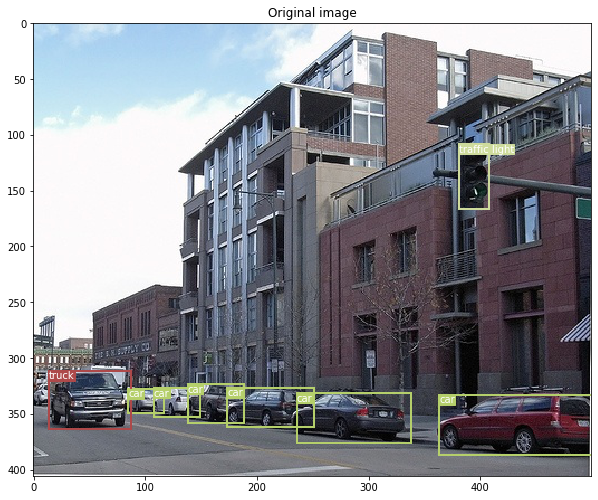

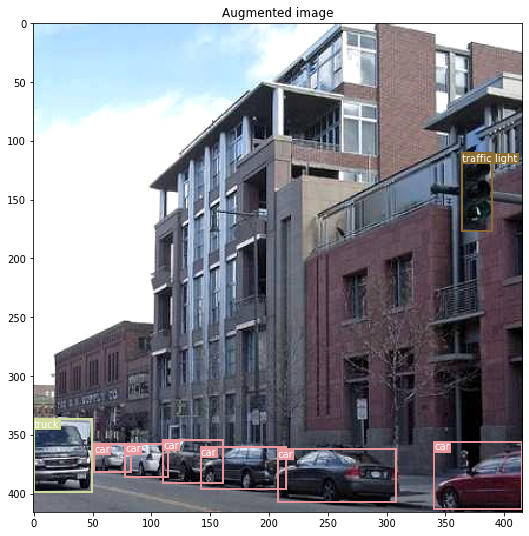

In [12]:
img_names = ['Original image', 'Augmented image']
for img_i, (img, detections) in enumerate(zip(imgs, img_detections)):
    cur_image_name = img_names[img_i]
    
    fig, ax = plt.subplots(1, figsize=(10, 9))
    ax.imshow(img)
    ax.title.set_text(cur_image_name)
    
    if detections is not None:
#         rescaled_detections = detections.clone()
        rescaled_detections = rescale_boxes(detections, img_size, img.shape[:2])
        unique_labels = rescaled_detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        print('\n' + cur_image_name)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in rescaled_detections[:]:
            print("Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )